In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install nibabel
!pip install monai



     |████████████████████████████████| 584 kB 635 kB/s eta 0:00:01


In [56]:
import logging
import os
import sys
import tempfile
from glob import glob

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

import monai
from monai.data import create_test_image_3d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
)
from monai.transforms import Activations, AddChannel, AsDiscrete, Compose, SaveImage, ScaleIntensity, EnsureType, NormalizeIntensity
from monai.visualize import plot_2d_or_3d_image

In [5]:
training_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
testing_path = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

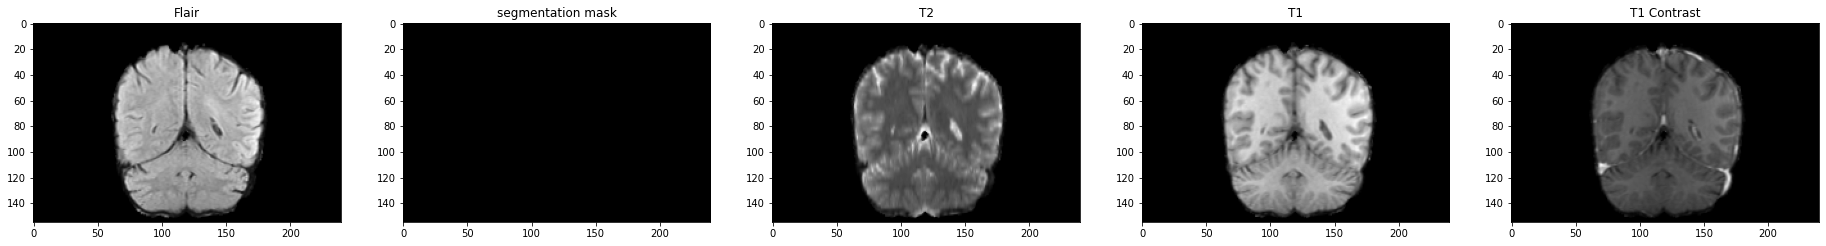



After scaling




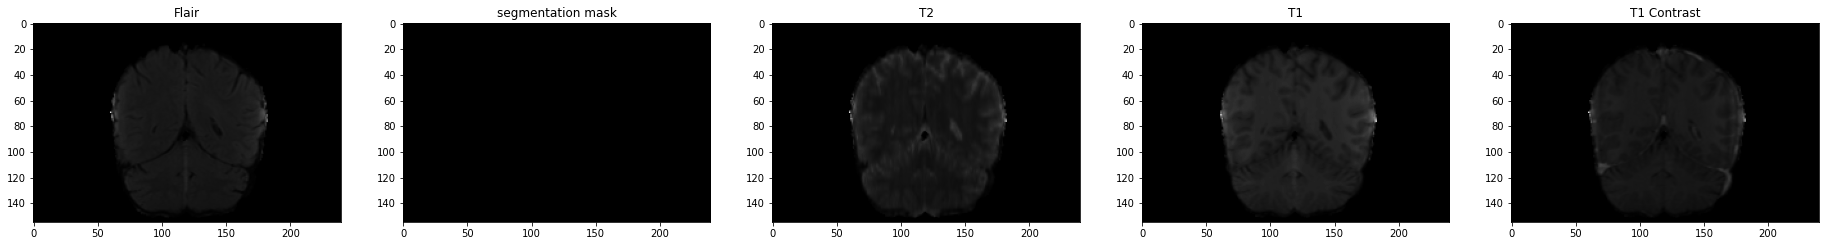

In [6]:
slice_number= 160
img_number = str(np.random.choice(355)).zfill(3)
flair_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_flair.nii").get_fdata()
seg_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_seg.nii").get_fdata()
t2_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_t2.nii").get_fdata()
t1_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_t1.nii").get_fdata()
t1ce_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_t1ce.nii").get_fdata()


plt.figure(figsize=(32,16))
plt.subplot(1,5,1)
plt.title("Flair")
plt.imshow(np.rot90(flair_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,2)
plt.title("segmentation mask")
plt.imshow(np.rot90(seg_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,3)
plt.title("T2")
plt.imshow(np.rot90(t2_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,4)
plt.title("T1")
plt.imshow(np.rot90(t1_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,5)
plt.title("T1 Contrast")
plt.imshow(np.rot90(t1ce_img_data[:,slice_number,:]),cmap='gray')
plt.show()

scalar = Normalizer()
normalized_flair_img_data =scalar.fit_transform(flair_img_data.reshape(-1, flair_img_data.shape[-1])).reshape(flair_img_data.shape)
normalized_seg_img_data= seg_img_data.astype(np.uint8)
normalized_t2_img_data =scalar.fit_transform(t2_img_data.reshape(-1, t2_img_data.shape[-1])).reshape(t2_img_data.shape)
normalized_t1_img_data =scalar.fit_transform(t1_img_data.reshape(-1, t1_img_data.shape[-1])).reshape(t1_img_data.shape) 
normalized_t1ce_img_data =scalar.fit_transform(t1ce_img_data.reshape(-1, t1ce_img_data.shape[-1])).reshape(t1ce_img_data.shape)

print("\n\nAfter scaling\n\n")

normalized_seg_img_data[normalized_seg_img_data > 1] = 0

plt.figure(figsize=(32,16))
plt.subplot(1,5,1)
plt.title("Flair")
plt.imshow(np.rot90(normalized_flair_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,2)
plt.title("segmentation mask")
plt.imshow(np.rot90(normalized_seg_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,3)
plt.title("T2")
plt.imshow(np.rot90(normalized_t2_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,4)
plt.title("T1")
plt.imshow(np.rot90(normalized_t1_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,5)
plt.title("T1 Contrast")
plt.imshow(np.rot90(normalized_t1ce_img_data[:,slice_number,:]),cmap='gray')
plt.show()

In [48]:
def get_file_names( data_path):
    images = []
    masks = []
    for dirname, _, filenames in os.walk(data_path):
        for filename in filenames:
            if "_flair.nii" in filename:
                if "BraTS20_Training_355_flair.nii" not in filename:
                    images.append(os.path.join(dirname, filename))
            if "seg.nii" in filename:
                masks.append(os.path.join(dirname, filename))



    images = sorted(images)
    masks = sorted(masks)
    img_seg_file_names = []
    for img, seg in zip(images, masks):
        img_seg_file_names.append({'img': img, "seg": seg})
    
    return img_seg_file_names

train_img_seg_file_names = get_file_names(training_path)
# test_image_paths, test_seg_paths = get_file_names(testing_path)

In [49]:
train_img_seg_file_names

[{'img': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii',
  'seg': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'},
 {'img': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii',
  'seg': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii'},
 {'img': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii',
  'seg': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii'},
 {'img': '../input/brats20-data

In [55]:
class ImageAndSegmentationMaskDataset(Dataset):
    def __init__(self, img_seg_file_names, img_transform=None, seg_transform=None):
        self.img_transform = img_transform
        self.seg_transform = seg_transform
        self.img_seg_file_names = img_seg_file_names
    def __len__(self):
        return len(self.img_seg_file_names)
    
    def __getitem__(self,index):
        img_path = self.img_seg_file_names[index]['img']
        seg_path = self.img_seg_file_names[index]['seg']
        img = nib.load(img_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()
        seg = seg.astype(np.uint8)
        seg[seg>1] = 0
        
        if self.img_transform:
            img = self.img_transform(img)
        if self.seg_transform:
            seg = self.seg_transform(seg)
            
            
        return {'img':img, 'seg':seg}
        
        

In [57]:
images = sorted(images)
masks = sorted(masks)
img_seg_file_names = []
for img, seg in zip(images, masks):
    img_seg_file_names.append({'img': img, "seg": seg})
    
    
# define transforms for image and segmentation
train_img_transforms = Compose([ScaleIntensity(), AddChannel(), EnsureType(), NormalizeIntensity])
train_seg_transforms = Compose([AddChannel(), EnsureType()])
val_img_transforms = Compose([ScaleIntensity(), AddChannel(), EnsureType(), NormalizeIntensity])
val_seg_transforms = Compose([AddChannel(), EnsureType()])

    
train_dataset = ImageAndSegmentationMaskDataset(train_img_seg_file_names, train_img_transforms, train_seg_transforms)
# val_dataset = ImageAndSegmentationMaskDataset(val_img_seg_file_names, val_img_transforms, val_seg_transforms)
len(train_dataset)

368

In [58]:
train_loader = DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=True,
        num_workers=4,
        collate_fn=list_data_collate,
        pin_memory=torch.cuda.is_available(),
    )
check_data = monai.utils.misc.first(train_loader)
print(check_data["img"].shape, check_data["seg"].shape)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/monai/data/utils.py", line 272, in list_data_collate
    ret[k] = default_collate([d[k] for d in data])
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 85, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'monai.transforms.intensity.array.NormalizeIntensity'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/monai/data/utils.py", line 296, in list_data_collate
    raise TypeError(re_str)
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'monai.transforms.intensity.array.NormalizeIntensity'>


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
model = monai.networks.nets.UNet(
        dimensions=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

In [45]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [54]:
 # start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
for epoch in range(5):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{5}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#         if (epoch + 1) % val_interval == 0:
#             model.eval()
#             with torch.no_grad():
#                 val_images = None
#                 val_labels = None
#                 val_outputs = None
#                 for val_data in val_loader:
#                     val_images, val_labels = val_data["img"].to(device), val_data["seg"].to(device)
#                     roi_size = (96, 96, 96)
#                     sw_batch_size = 4
#                     val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
#                     val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
#                     # compute metric for current iteration
#                     dice_metric(y_pred=val_outputs, y=val_labels)
#                 # aggregate the final mean dice result
#                 metric = dice_metric.aggregate().item()
#                 # reset the status for next validation round
#                 dice_metric.reset()

#                 metric_values.append(metric)
#                 if metric > best_metric:
#                     best_metric = metric
#                     best_metric_epoch = epoch + 1
#                     torch.save(model.state_dict(), "best_metric_model_segmentation3d_dict.pth")
#                     print("saved new best metric model")
#                 print(
#                     "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
#                         epoch + 1, metric, best_metric, best_metric_epoch
#                     )
#                 )
#                 writer.add_scalar("val_mean_dice", metric, epoch + 1)
#                 # plot the last model output as GIF image in TensorBoard with the corresponding image and label
#                 plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
#                 plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
#                 plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

#     print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()


----------
epoch 1/5


RuntimeError: expected scalar type Double but found Float

###### Annotations comprise of 
* label 1: necrotic and non-enhancing tumor core (NCR/NET)
* label 2: peritumoral edema (ED) 
* label 4: GD-enhancing tumor (ET) 


In [ ]:
glob(os.path.join(training_path,"*_flair.nii"),recursive=True)

In [25]:
plot_2d_or_3d_image()

'img'